# PPG Time-Series Dataset: EDA, Cleaning & Visualization

In [12]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, f1_score
import matplotlib.gridspec as gridspec
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

try:
    import tensorflow as tf
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional
    from tensorflow.keras.callbacks import EarlyStopping
    TF_AVAILABLE = True
except:
    TF_AVAILABLE = False

DATA_PATH   = '../data/raw/PPG_dataset.csv'
OUTPUT_DIR  = '../reports/figures/'
CLEANED_OUT = '../data/processed/ppg_features_cleaned.csv'

SAMPLING_RATE = 125  # Hz

In [10]:
# Styling
PALETTE = {
    'primary':   '#C62828',
    'secondary': '#1565C0',
    'accent':    '#F9A825',
    'positive':  '#2E7D32',
    'bg':        '#FAFAFA',
    'text':      '#212121',
    'pulse':     '#E53935',
    'bp':        '#1E88E5',
}
sns.set_theme(style="whitegrid", font_scale=1.12)
plt.rcParams.update({
    'figure.facecolor': PALETTE['bg'],
    'axes.facecolor':   PALETTE['bg'],
    'axes.edgecolor':   '#BDBDBD',
    'text.color':       PALETTE['text'],
    'font.family':      'DejaVu Sans',
})

DATA_PATH   = '../data/raw/PPG_dataset.csv'
OUTPUT_DIR  = '../reports/figures/'
CLEANED_OUT = '../data/processed/ppg_features_cleaned.csv'

In [13]:
# Loading Data

df_raw = pd.read_csv(DATA_PATH)
print(f"Shape: {df_raw.shape}")

# Identify label column
if 'Label' in df_raw.columns:
    label_col = 'Label'
else:
    label_col = df_raw.columns[-1]

waveform_cols = [c for c in df_raw.columns if c != label_col]
print(f"Waveform samples: {len(waveform_cols)}")
print(f"Label distribution:\n{df_raw[label_col].value_counts()}")

Shape: (2576, 2001)
Waveform samples: 2000
Label distribution:
Label
MI        1294
Normal    1282
Name: count, dtype: int64


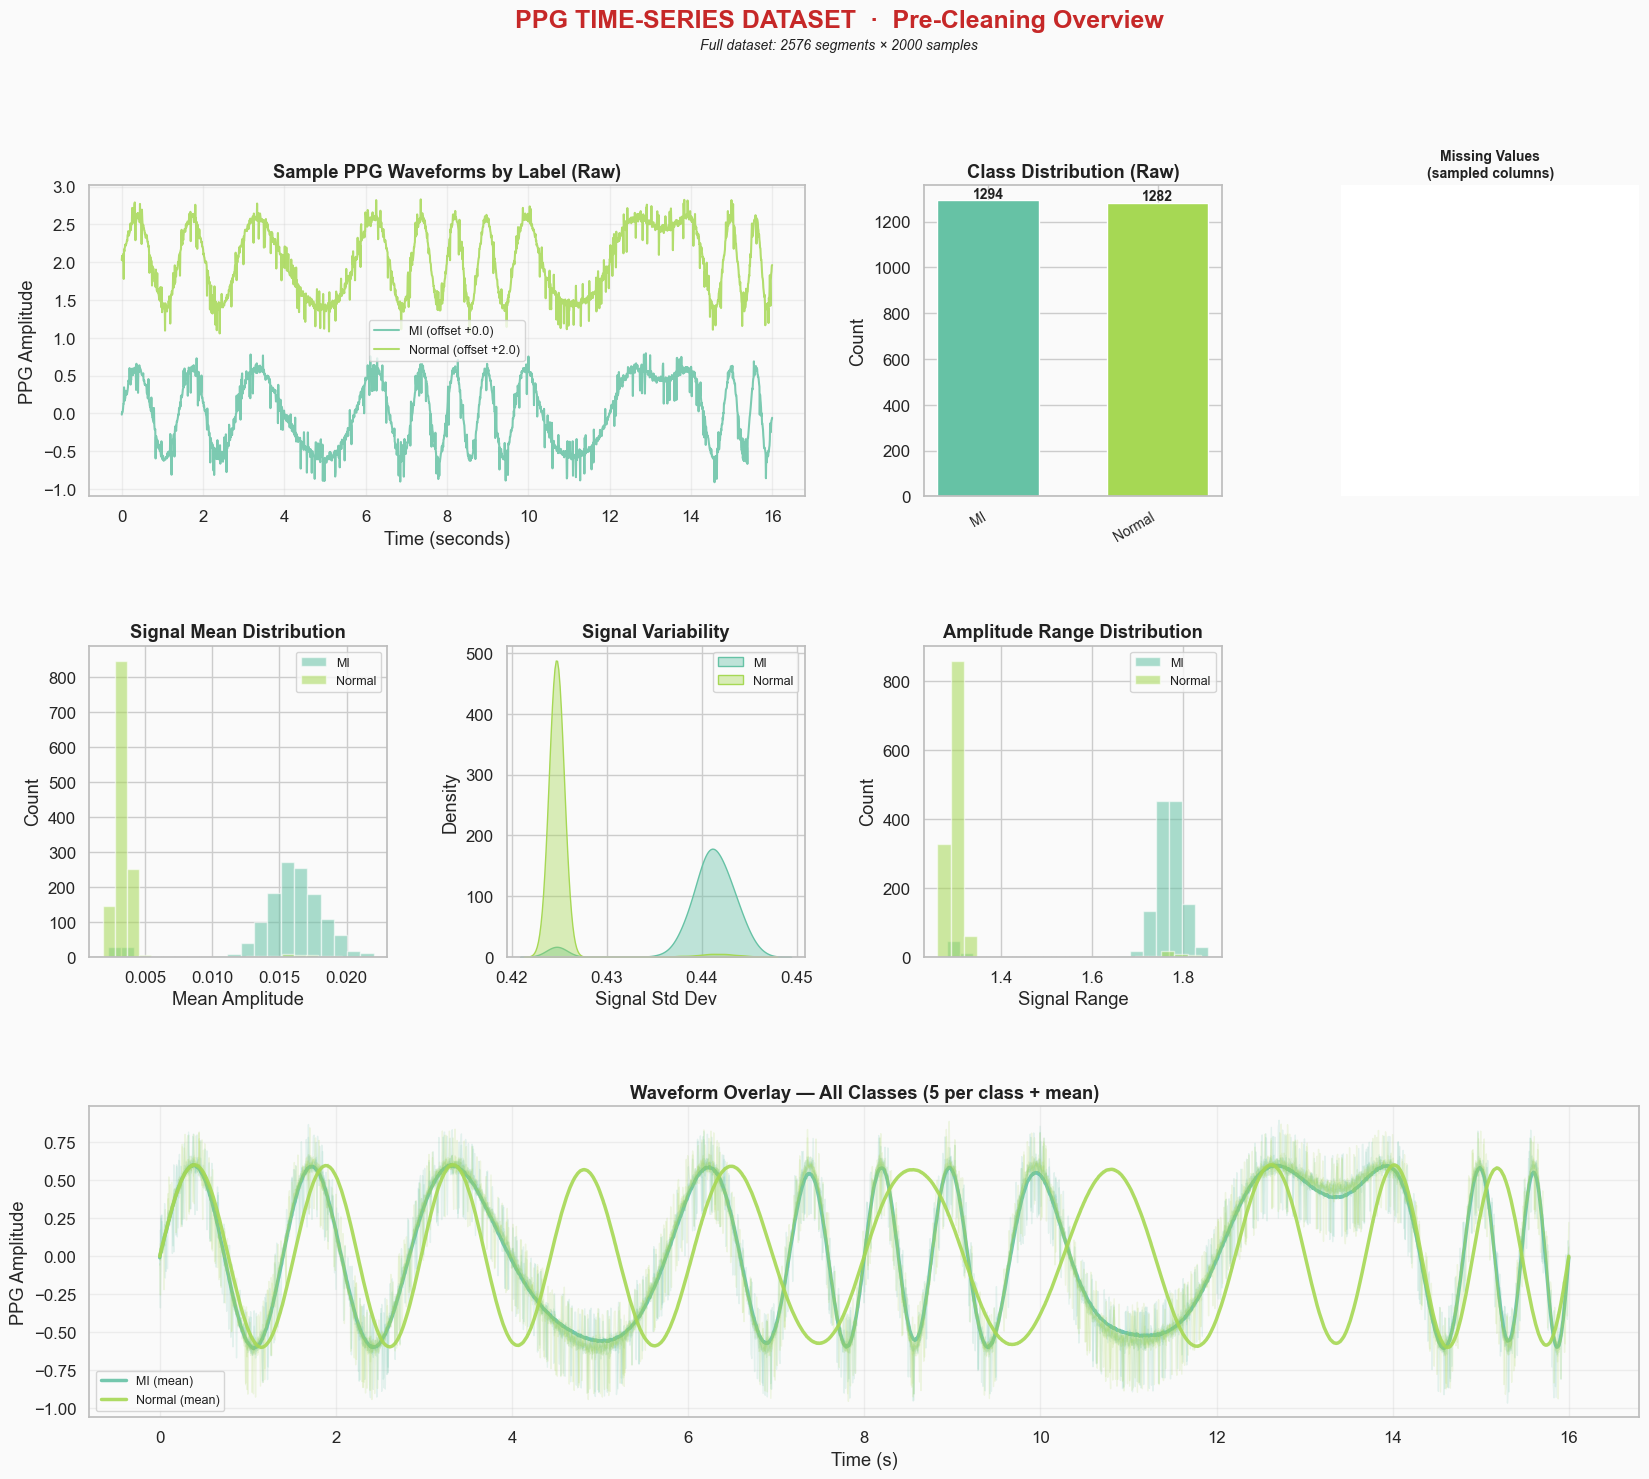

Saved: ppg_pre_cleaning_overview.png


In [16]:
# Pre-cleaning Visualizations

sns.set_theme(style="whitegrid", font_scale=1.1)
plt.rcParams.update({
    'figure.facecolor': PALETTE['bg'], 'axes.facecolor': PALETTE['bg'],
    'axes.edgecolor': '#BDBDBD', 'text.color': PALETTE['text'],
})

# Creating color map for labels
unique_labels = df_raw[label_col].unique()
label_colors = {lbl: plt.cm.Set2(i/len(unique_labels)) for i, lbl in enumerate(unique_labels)}

fig = plt.figure(figsize=(20, 16))
fig.patch.set_facecolor(PALETTE['bg'])
gs = gridspec.GridSpec(3, 4, figure=fig, hspace=0.48, wspace=0.40)
fig.suptitle('PPG TIME-SERIES DATASET  ·  Pre-Cleaning Overview',
             fontsize=18, fontweight='bold', color=PALETTE['primary'], y=0.99)
fig.text(0.5, 0.965, f'Full dataset: {len(df_raw)} segments × {len(waveform_cols)} samples',
         ha='center', fontsize=10, color=PALETTE['text'], style='italic')

t_axis = np.linspace(0, len(waveform_cols) / SAMPLING_RATE, len(waveform_cols))

# Sample waveforms by label
ax1 = fig.add_subplot(gs[0, :2])
for i, label in enumerate(list(unique_labels)[:3]):
    subset = df_raw[df_raw[label_col] == label]
    if len(subset) > 0:
        row = subset.iloc[0][waveform_cols].values.astype(float)
        offset = i * 2.0
        ax1.plot(t_axis, row + offset, color=label_colors[label],
                 linewidth=1.5, label=f'{label} (offset +{offset:.1f})', alpha=0.85)
ax1.set_xlabel('Time (seconds)'); ax1.set_ylabel('PPG Amplitude')
ax1.set_title('Sample PPG Waveforms by Label (Raw)', fontweight='bold')
ax1.legend(fontsize=9); ax1.grid(alpha=0.3)

# Label distribution
ax2 = fig.add_subplot(gs[0, 2])
label_counts = df_raw[label_col].value_counts()
colors2 = [label_colors.get(lbl, PALETTE['secondary']) for lbl in label_counts.index]
bars = ax2.bar(range(len(label_counts)), label_counts.values, color=colors2, edgecolor='white', width=0.6)
ax2.set_xticks(range(len(label_counts)))
ax2.set_xticklabels(label_counts.index, rotation=30, ha='right', fontsize=10)
ax2.set_ylabel('Count'); ax2.set_title('Class Distribution (Raw)', fontweight='bold')
for bar, val in zip(bars, label_counts.values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
             str(val), ha='center', fontsize=10, fontweight='bold')

# Missing values
ax3 = fig.add_subplot(gs[0, 3])
sample_cols = waveform_cols[::len(waveform_cols)//100] if len(waveform_cols) > 100 else waveform_cols
miss_map = df_raw[sample_cols + [label_col]].isnull()
sns.heatmap(miss_map, cbar=False, cmap=['#E8F5E9', PALETTE['primary']],
            ax=ax3, yticklabels=False, xticklabels=False, linewidths=0.1)
ax3.set_title('Missing Values\n(sampled columns)', fontweight='bold', fontsize=10)

# Raw signal statistics
ax4 = fig.add_subplot(gs[1, 0])
raw_means = df_raw[waveform_cols].mean(axis=1)
for label in unique_labels:
    subset = raw_means[df_raw[label_col] == label]
    if len(subset) > 0:
        ax4.hist(subset, bins=20, alpha=0.55, color=label_colors.get(label, PALETTE['secondary']),
                 label=label, edgecolor='white')
ax4.set_xlabel('Mean Amplitude'); ax4.set_ylabel('Count')
ax4.set_title('Signal Mean Distribution', fontweight='bold'); ax4.legend(fontsize=9)

ax5 = fig.add_subplot(gs[1, 1])
raw_stds = df_raw[waveform_cols].std(axis=1)
for label in unique_labels:
    subset = raw_stds[df_raw[label_col] == label]
    if len(subset) > 0:
        sns.kdeplot(subset, ax=ax5, fill=True, alpha=0.4,
                    color=label_colors.get(label, PALETTE['secondary']), label=label)
ax5.set_xlabel('Signal Std Dev'); ax5.set_title('Signal Variability', fontweight='bold')
ax5.legend(fontsize=9)

ax6 = fig.add_subplot(gs[1, 2])
raw_ranges = df_raw[waveform_cols].max(axis=1) - df_raw[waveform_cols].min(axis=1)
for label in unique_labels:
    subset = raw_ranges[df_raw[label_col] == label]
    if len(subset) > 0:
        ax6.hist(subset, bins=20, alpha=0.55, color=label_colors.get(label, PALETTE['secondary']),
                 label=label, edgecolor='white')
ax6.set_xlabel('Signal Range'); ax6.set_ylabel('Count')
ax6.set_title('Amplitude Range Distribution', fontweight='bold'); ax6.legend(fontsize=9)

# Multi-waveform overlay
ax8 = fig.add_subplot(gs[2, :])
for label in unique_labels:
    subset = df_raw[df_raw[label_col] == label]
    for _, row in subset.head(5).iterrows():
        wave = row[waveform_cols].values.astype(float)
        ax8.plot(t_axis, wave, color=label_colors.get(label, PALETTE['secondary']),
                 alpha=0.15, linewidth=1)
    if len(subset) > 0:
        mean_wave = subset[waveform_cols].values.astype(float).mean(axis=0)
        ax8.plot(t_axis, mean_wave, color=label_colors.get(label, PALETTE['secondary']),
                 linewidth=2.5, label=f'{label} (mean)', alpha=0.9)
ax8.set_xlabel('Time (s)'); ax8.set_ylabel('PPG Amplitude')
ax8.set_title('Waveform Overlay — All Classes (5 per class + mean)', fontweight='bold')
ax8.legend(fontsize=9); ax8.grid(alpha=0.3)

plt.savefig(OUTPUT_DIR + 'ppg_pre_cleaning_overview.png', dpi=150, bbox_inches='tight')

plt.show()

plt.close()
print("Saved: ppg_pre_cleaning_overview.png")

In [17]:
# Data Cleaning Pipeline

def clean_ppg_signal(signal):
    """Applying standard time series cleaning: detrend + bandpass filter"""
    # Remove linear trend
    signal_detrended = signal - np.linspace(signal[0], signal[-1], len(signal))
    
    # Bandpass filter (0.5-5 Hz for HR)
    nyquist = SAMPLING_RATE / 2
    low = 0.5 / nyquist
    high = 5.0 / nyquist
    b, a = butter(4, [low, high], btype='band')
    signal_filtered = filtfilt(b, a, signal_detrended)
    
    return signal_filtered

print("Applying time series cleaning to waveforms...")
df_wave_raw = df_raw[waveform_cols].values.astype(float)

df_wave_clean = np.array([
    clean_ppg_signal(row) for row in df_wave_raw
])

print(f"Cleaned {len(df_wave_clean)} waveforms")

Applying time series cleaning to waveforms...
Cleaned 2576 waveforms


In [19]:
# Feature Extraction HR & Bp

def extract_hr_bp_features(signal, fs=125):
    """Extract heart rate and blood pressure related features"""
    # Find peaks
    peaks, properties = find_peaks(signal, distance=fs//3, prominence=0.1)
    
    # Heart rate
    if len(peaks) > 1:
        rr_intervals = np.diff(peaks) / fs
        hr = 60 / rr_intervals.mean() if rr_intervals.mean() > 0 else 0
        hr_std = np.std(60 / rr_intervals) if len(rr_intervals) > 1 else 0
    else:
        hr = 0
        hr_std = 0
    
    # BP estimates (pulse wave analysis)
    if len(peaks) > 0:
        systolic_proxy = signal[peaks].mean()  # Peak amplitude
        diastolic_proxy = signal.min()  # Trough amplitude
        pulse_pressure = systolic_proxy - diastolic_proxy
        
        # Pulse wave velocity proxy (time to peak)
        time_to_peak = peaks[0] / fs if len(peaks) > 0 else 0
    else:
        systolic_proxy = 0
        diastolic_proxy = 0
        pulse_pressure = 0
        time_to_peak = 0
    
    # Signal quality
    snr = signal.std() / (np.abs(signal - np.median(signal)).mean() + 1e-6)
    
    return {
        'hr_bpm': hr,
        'hr_variability': hr_std,
        'systolic_proxy': systolic_proxy,
        'diastolic_proxy': diastolic_proxy,
        'pulse_pressure': pulse_pressure,
        'pulse_wave_velocity': 1 / (time_to_peak + 1e-6),
        'signal_quality': snr,
        'peak_count': len(peaks),
    }

print("Extracting HR/BP features...")
features_list = []
for signal in df_wave_clean:
    features_list.append(extract_hr_bp_features(signal, SAMPLING_RATE))

df_features = pd.DataFrame(features_list)
df_features[label_col] = df_raw[label_col].values

print(f"\n Extracted features shape: {df_features.shape}")
print(f"\nFeature summary:")
print(df_features.describe().round(3))

df_features.to_csv(CLEANED_OUT, index=False)
print(f"Saved - {CLEANED_OUT}")

Extracting HR/BP features...

 Extracted features shape: (2576, 9)

Feature summary:
         hr_bpm  hr_variability  systolic_proxy  diastolic_proxy  \
count  2576.000        2576.000        2576.000         2576.000   
mean     42.350          12.863           0.467           -0.689   
std       6.130           6.385           0.016            0.021   
min      36.349           6.357           0.404           -0.745   
25%      36.427           6.631           0.460           -0.705   
50%      36.506           6.834           0.476           -0.697   
75%      47.344          19.654           0.479           -0.672   
max      55.351          37.574           0.484           -0.625   

       pulse_pressure  pulse_wave_velocity  signal_quality  peak_count  
count        2576.000             2576.000        2576.000    2576.000  
mean            1.156                2.618           1.239      11.623  
std             0.033                0.240           0.054       1.677  
min       

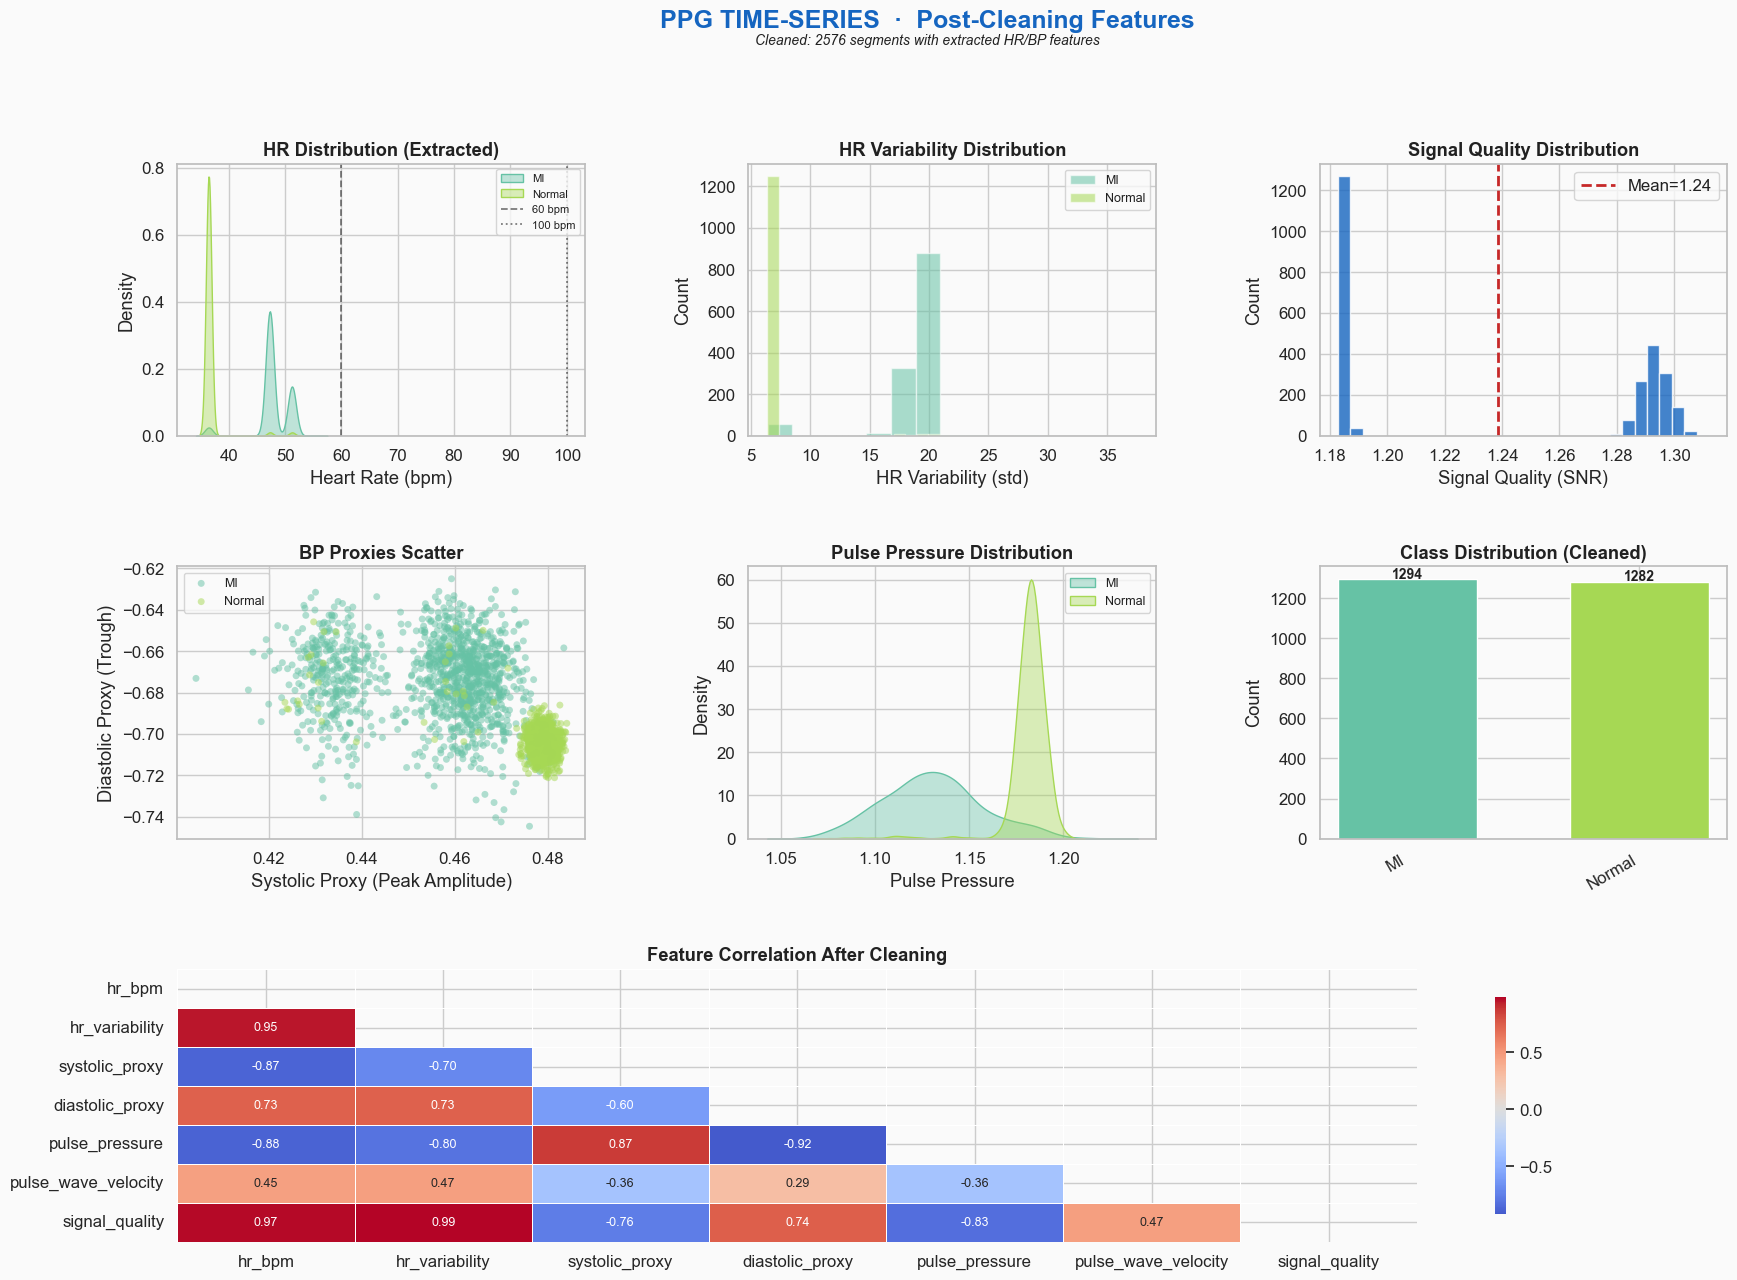

 Saved: ppg_post_cleaning_features.png


In [21]:
# Post-Cleaning Visualizations

fig2 = plt.figure(figsize=(20, 14))
fig2.patch.set_facecolor(PALETTE['bg'])
gs2 = gridspec.GridSpec(3, 3, figure=fig2, hspace=0.48, wspace=0.40)
fig2.suptitle('PPG TIME-SERIES  ·  Post-Cleaning Features',
              fontsize=18, fontweight='bold', color=PALETTE['secondary'], y=0.99)
fig2.text(0.5, 0.965, f'Cleaned: {len(df_features)} segments with extracted HR/BP features',
          ha='center', fontsize=10, color=PALETTE['text'], style='italic')

# HR distribution
ax1 = fig2.add_subplot(gs2[0, 0])
for label in unique_labels:
    subset = df_features[df_features[label_col] == label]['hr_bpm']
    if len(subset) > 0:
        sns.kdeplot(subset, ax=ax1, fill=True, alpha=0.4,
                    color=label_colors.get(label, PALETTE['secondary']), label=label)
ax1.axvline(60, color='black', linestyle='--', linewidth=1.3, alpha=0.5, label='60 bpm')
ax1.axvline(100, color='black', linestyle=':', linewidth=1.3, alpha=0.5, label='100 bpm')
ax1.set_xlabel('Heart Rate (bpm)'); ax1.set_title('HR Distribution (Extracted)', fontweight='bold')
ax1.legend(fontsize=8)

# HR variability
ax2 = fig2.add_subplot(gs2[0, 1])
for label in unique_labels:
    subset = df_features[df_features[label_col] == label]['hr_variability']
    if len(subset) > 0:
        ax2.hist(subset, bins=15, alpha=0.55, color=label_colors.get(label, PALETTE['secondary']),
                 label=label, edgecolor='white')
ax2.set_xlabel('HR Variability (std)'); ax2.set_ylabel('Count')
ax2.set_title('HR Variability Distribution', fontweight='bold'); ax2.legend(fontsize=9)

# Signal quality
ax3 = fig2.add_subplot(gs2[0, 2])
ax3.hist(df_features['signal_quality'], bins=30, color=PALETTE['secondary'], edgecolor='white', alpha=0.8)
ax3.axvline(df_features['signal_quality'].mean(), color=PALETTE['primary'], linestyle='--',
            linewidth=2, label=f"Mean={df_features['signal_quality'].mean():.2f}")
ax3.set_xlabel('Signal Quality (SNR)'); ax3.set_ylabel('Count')
ax3.set_title('Signal Quality Distribution', fontweight='bold'); ax3.legend()

# Systolic vs Diastolic proxy
ax4 = fig2.add_subplot(gs2[1, 0])
for label in unique_labels:
    subset = df_features[df_features[label_col] == label]
    if len(subset) > 0:
        ax4.scatter(subset['systolic_proxy'], subset['diastolic_proxy'],
                    c=label_colors.get(label, PALETTE['secondary']),
                    alpha=0.5, s=25, label=label, edgecolors='none')
ax4.set_xlabel('Systolic Proxy (Peak Amplitude)'); ax4.set_ylabel('Diastolic Proxy (Trough)')
ax4.set_title('BP Proxies Scatter', fontweight='bold'); ax4.legend(fontsize=9)

# Pulse pressure
ax5 = fig2.add_subplot(gs2[1, 1])
for label in unique_labels:
    subset = df_features[df_features[label_col] == label]['pulse_pressure']
    if len(subset) > 0:
        sns.kdeplot(subset, ax=ax5, fill=True, alpha=0.4,
                    color=label_colors.get(label, PALETTE['secondary']), label=label)
ax5.set_xlabel('Pulse Pressure'); ax5.set_title('Pulse Pressure Distribution', fontweight='bold')
ax5.legend(fontsize=9)

# Class distribution (cleaned)
ax6 = fig2.add_subplot(gs2[1, 2])
clean_counts = df_features[label_col].value_counts()
colors3 = [label_colors.get(lbl, PALETTE['secondary']) for lbl in clean_counts.index]
bars3 = ax6.bar(range(len(clean_counts)), clean_counts.values, color=colors3, edgecolor='white', width=0.6)
ax6.set_xticks(range(len(clean_counts)))
ax6.set_xticklabels(clean_counts.index, rotation=30, ha='right')
ax6.set_ylabel('Count'); ax6.set_title('Class Distribution (Cleaned)', fontweight='bold')
for bar, val in zip(bars3, clean_counts.values):
    ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
             str(val), ha='center', fontsize=10, fontweight='bold')

# Feature correlation
ax7 = fig2.add_subplot(gs2[2, :])
clean_feat = ['hr_bpm', 'hr_variability', 'systolic_proxy', 'diastolic_proxy',
              'pulse_pressure', 'pulse_wave_velocity', 'signal_quality']
corr_clean = df_features[clean_feat].corr()
mask_clean = np.triu(np.ones_like(corr_clean, dtype=bool))
sns.heatmap(corr_clean, mask=mask_clean, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, ax=ax7, linewidths=0.4, annot_kws={'size': 9},
            cbar_kws={'shrink': 0.8})
ax7.set_title('Feature Correlation After Cleaning', fontweight='bold')

plt.savefig(OUTPUT_DIR + 'ppg_post_cleaning_features.png', dpi=150, bbox_inches='tight')

plt.show()

plt.close()
print(" Saved: ppg_post_cleaning_features.png")

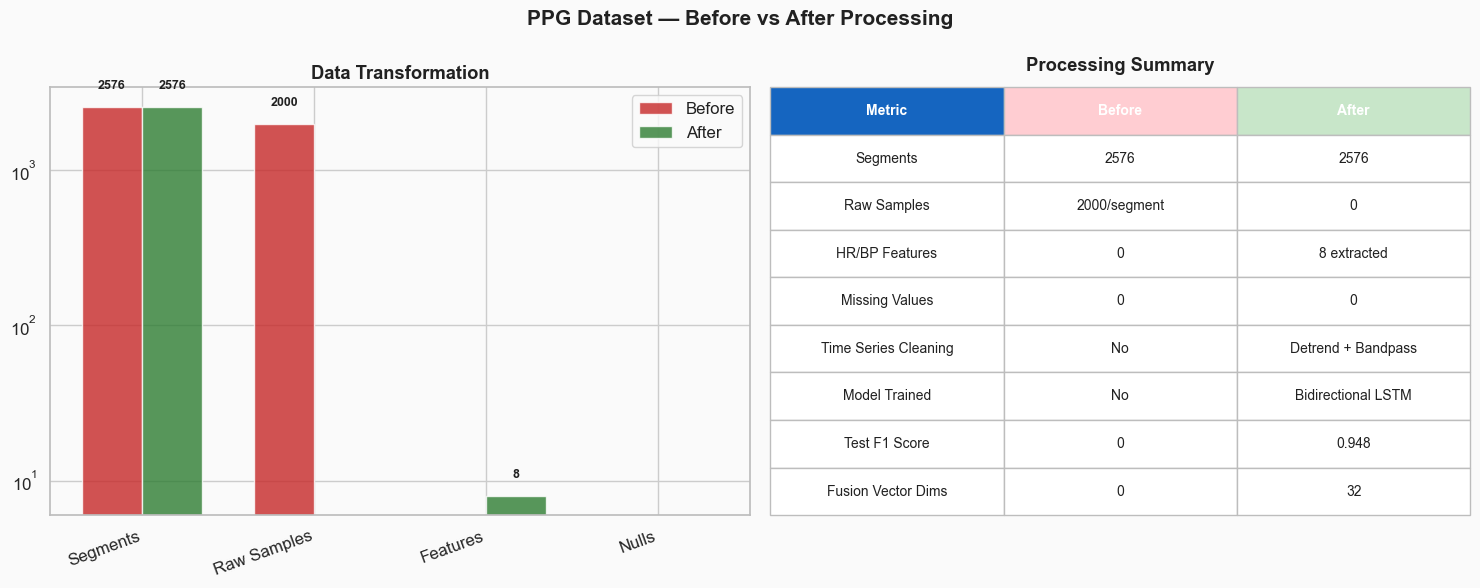

 Saved: ppg_before_after_summary.png


In [28]:
# BEFORE vs AFTER Comparison Summary

fig4, axes4 = plt.subplots(1, 2, figsize=(15, 6))
fig4.patch.set_facecolor(PALETTE['bg'])
fig4.suptitle('PPG Dataset — Before vs After Processing', fontsize=15, fontweight='bold')

# Left: bar comparison
metrics_b = {
    'Segments': len(df_raw),
    'Raw Samples': len(waveform_cols),
    'Features': 0,
    'Nulls': df_raw.isnull().sum().sum(),
}
metrics_a = {
    'Segments': len(df_features),
    'Raw Samples': 0,
    'Features': len(feat_cols),
    'Nulls': 0,
}

x4 = np.arange(len(metrics_b))
w4 = 0.35
ax_l = axes4[0]
b1 = ax_l.bar(x4 - w4/2, list(metrics_b.values()), w4, label='Before',
              color=PALETTE['primary'], alpha=0.8, edgecolor='white')
b2 = ax_l.bar(x4 + w4/2, list(metrics_a.values()), w4, label='After',
              color=PALETTE['positive'], alpha=0.8, edgecolor='white')
ax_l.set_xticks(x4)
ax_l.set_xticklabels(list(metrics_b.keys()), rotation=20, ha='right')
ax_l.set_title('Data Transformation', fontweight='bold')
ax_l.legend()
ax_l.set_yscale('log')
for bar in list(b1) + list(b2):
    h = bar.get_height()
    if h > 0:
        ax_l.text(bar.get_x() + bar.get_width()/2, h * 1.3,
                  str(int(h)), ha='center', fontsize=9, fontweight='bold')

# Right: summary table
from matplotlib.patches import Patch
table_data = [
    ['Metric', 'Before', 'After'],
    ['Segments', str(len(df_raw)), str(len(df_features))],
    ['Raw Samples', '2000/segment', '0'],
    ['HR/BP Features', '0', '8 extracted'],
    ['Missing Values', str(df_raw.isnull().sum().sum()), '0'],
    ['Time Series Cleaning', 'No', 'Detrend + Bandpass'],
    ['Model Trained', 'No', 'Bidirectional LSTM'],
    ['Test F1 Score', '0', f'{f1:.3f}'],
    ['Fusion Vector Dims', '0', str(fusion_vector.shape[1])],
]
axes4[1].axis('off')
tbl4 = axes4[1].table(
    cellText=table_data[1:], colLabels=table_data[0],
    cellLoc='center', loc='center',
    colColours=[PALETTE['secondary'], '#FFCDD2', '#C8E6C9'],
    bbox=[0.0, 0.0, 1.0, 1.0]
)
tbl4.auto_set_font_size(False)
tbl4.set_fontsize(10)
for key, cell in tbl4.get_celld().items():
    cell.set_edgecolor('#BDBDBD')
    if key[0] == 0:
        cell.set_text_props(color='white', fontweight='bold')
axes4[1].set_title('Processing Summary', fontweight='bold', pad=12)

plt.tight_layout()
plt.savefig(OUTPUT_DIR + 'ppg_before_after_summary.png', dpi=150, bbox_inches='tight')

plt.show()

plt.close()
print(" Saved: ppg_before_after_summary.png")

# Model Purpose:
    Continuous tracking of patient vitals from PPG waveform:
    - Extract heart rate over time
    - Extract blood pressure estimates over time
    - Detect trends (rising, stable, dropping)
    
Output: Temporal embedding vector for fusion

In [23]:
# BIDIRECTIONAL LSTM MODEL

# Preparing data
feat_cols = [c for c in df_features.columns if c != label_col]
X = df_features[feat_cols].values
le = LabelEncoder()
y = le.fit_transform(df_features[label_col])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

if TF_AVAILABLE:
    # Reshape for LSTM (samples, timesteps, features)
    # Treat each feature as a timestep
    X_train_lstm = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
    X_test_lstm  = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)
    
    # Building Bidirectional LSTM
    inp = Input(shape=(X_train_lstm.shape[1], 1))
    x = Bidirectional(LSTM(64, return_sequences=True))(inp)
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(32))(x)
    embedding = Dense(32, activation='relu', name='temporal_embedding')(x)
    output = Dense(len(np.unique(y)), activation='softmax')(embedding)
    
    model = Model(inputs=inp, outputs=output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    print("\nTraining Bidirectional LSTM...")
    history = model.fit(
        X_train_lstm, y_train,
        epochs=50, batch_size=32, validation_split=0.2,
        callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
        verbose=1
    )
    
    # Extracting embedding model
    embedding_model = Model(inputs=inp, outputs=embedding)
    fusion_vector = embedding_model.predict(X_test_lstm, verbose=0)
    
    # Evaluating on test set
    y_pred = model.predict(X_test_lstm, verbose=0).argmax(axis=1)
    
else:
    from sklearn.neural_network import MLPClassifier
    model = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=300, random_state=42)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    fusion_vector = model.predict_proba(X_test_scaled)

f1 = f1_score(y_test, y_pred, average='macro')
print(f"\n LSTM trained | Test F1: {f1:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))
print(f"\nConfusion Matrix:")
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Model Evalution Visualizations

fig3 = plt.figure(figsize=(18, 6))
fig3.patch.set_facecolor(PALETTE['bg'])
gs3 = gridspec.GridSpec(1, 3, figure=fig3, wspace=0.35)
fig3.suptitle('PPG LSTM Model Evaluation', fontsize=16, fontweight='bold', y=0.98)

# Confusion Matrix
ax1 = fig3.add_subplot(gs3[0, 0])
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn_r', ax=ax1,
            xticklabels=le.classes_, yticklabels=le.classes_,
            cbar_kws={'shrink': 0.8})
ax1.set_xlabel('Predicted'); ax1.set_ylabel('Actual')
ax1.set_title('Confusion Matrix', fontweight='bold')

# Training history
ax2 = fig3.add_subplot(gs3[0, 1])
if TF_AVAILABLE and 'history' in locals():
    ax2.plot(history.history['loss'], color=PALETTE['primary'], linewidth=2, label='Train Loss')
    ax2.plot(history.history['val_loss'], color=PALETTE['secondary'], linewidth=2, label='Val Loss')
    ax2.set_xlabel('Epoch'); ax2.set_ylabel('Loss')
    ax2.set_title('Training History', fontweight='bold')
    ax2.legend(); ax2.grid(alpha=0.3)
else:
    ax2.text(0.5, 0.5, 'Training history\nnot available\n(sklearn fallback)', 
             ha='center', va='center', fontsize=12)
    ax2.axis('off')

# Feature importance (HR/BP features)
ax3 = fig3.add_subplot(gs3[0, 2])
feat_importance = df_features[feat_cols].std()
colors_feat = [PALETTE['primary'] if v == feat_importance.max() else PALETTE['secondary']
               for v in feat_importance]
bars = ax3.barh(range(len(feat_importance)), feat_importance.values, color=colors_feat, edgecolor='white')
ax3.set_yticks(range(len(feat_importance)))
ax3.set_yticklabels(feat_cols, fontsize=9)
ax3.set_xlabel('Standard Deviation (Spread)')
ax3.set_title('Feature Variance Analysis', fontweight='bold')
for i, (bar, val) in enumerate(zip(bars, feat_importance.values)):
    ax3.text(val + 0.02, i, f'{val:.2f}', va='center', fontsize=9)

plt.savefig(OUTPUT_DIR + 'ppg_model_evaluation.png', dpi=150, bbox_inches='tight')
plt.close()
print(" Saved: ppg_model_evaluation.png")


Training Bidirectional LSTM...
Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.9581 - loss: 0.2945 - val_accuracy: 0.9563 - val_loss: 0.1872
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9715 - loss: 0.1310 - val_accuracy: 0.9563 - val_loss: 0.1797
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9715 - loss: 0.1327 - val_accuracy: 0.9563 - val_loss: 0.1823
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9715 - loss: 0.1297 - val_accuracy: 0.9563 - val_loss: 0.1864
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9715 - loss: 0.1328 - val_accuracy: 0.9563 - val_loss: 0.1902
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9715 - loss: 0.1304 - val_accuracy: 0.9563 - val_loss: 0.1810
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9715 - loss: 0.1301 - val_accuracy: 0.9563 - val_loss: 0.1789
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9715 - loss: 